The Winter Olympics are built for snow, ice and mountains. Unsurprisingly, countries like Norway, Canada and Switzerland dominate the medal table year after year.

However, Australia seems to be an exception to this story.

<img src="img/ausolympics.png" width="60%">
Source: <a href="https://www.theguardian.com/sport/2026/feb/17/how-did-australia-get-so-good-winter-olympics-gold-medals-tally-count">The Guardian</a>

In recent years, Australia's performance at the winter olympics has been consistently improving, with them putting up the best performance yet this year, obtaining a total of 6 medals (at the time of writing this blog), beating the previous record by 2 medals set in 2022. While this is by no means as impressive as the 37 medals won by the first place, Norway, Australia is placed 14th on the leaderboard and all 13 countries which have performed better are in the Northern Hemisphere.

According to The Guardian article, it is said that their success has come "through clever strategy and targeted resource allocation." Out of the 16 different disciplines in the winter olympics, all of Australia's medals came from two: freestyle skiing (moguls), and snowboarding. 

This contrast raised a broader question for me:

Do traditionally "wintry" countries succeed because they diversify across many disciplines, while warmer nations survive through strategic specialisation? And is diversification a luxury available only to large, cold countries?

Using historical Winter Olympics data, this analysis explores whether geography shapes not just who wins, but how they win.

### Setup

In [13]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

wolympics_df = pd.read_csv('data/winter_olympics_medals.csv')

wolympics_df = wolympics_df[~wolympics_df['year'].isin([2012,2016])]


wolympics_df.sample(20)
bios_df = pd.read_csv('data/bios.csv')
pop_df = pd.read_csv('data/populations.csv')
medals_df = wolympics_df[wolympics_df["medal"].notna()].copy()

world = gpd.read_file("data/worldmap.json")
region_lookup = world[["iso_a3", "continent", "region_un", "subregion"]].copy()


In [24]:
country_totals = (
    medals_df.groupby("noc")
    .size()
    .reset_index(name="medals_total")
    .sort_values("medals_total", ascending=False)
)

country_totals.head(5)

,noc,medals_total
5,CAN,795
51,USA,772
34,NOR,600
20,GER,551
14,FIN,513


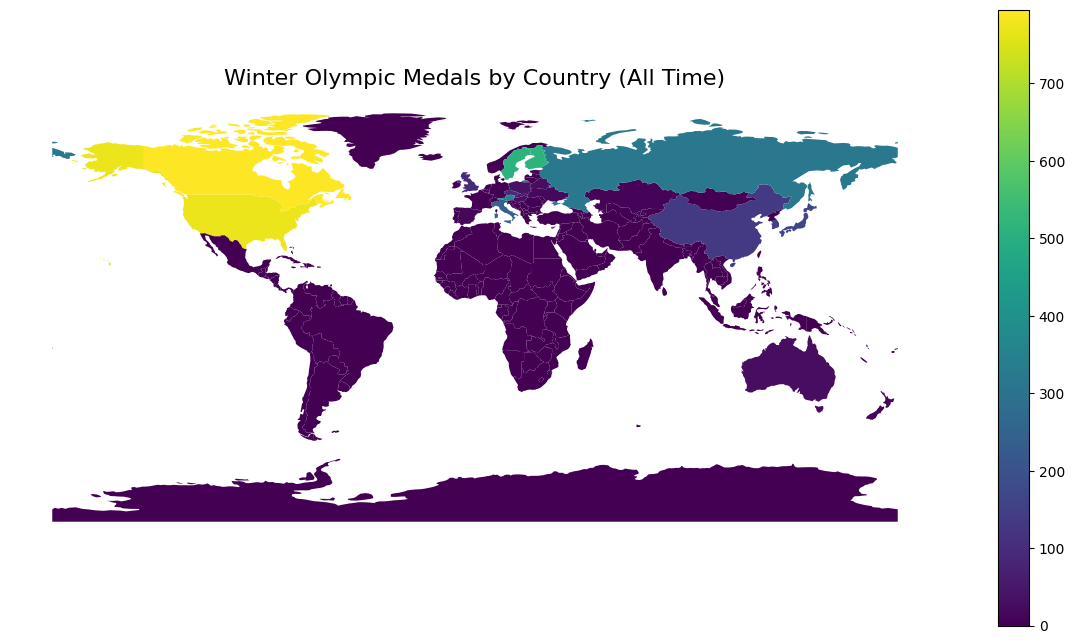

In [29]:
medals_with_region = country_totals.merge(
    region_lookup,
    left_on="noc",
    right_on="iso_a3",
    how="left"
)

world_medals = world.merge(
    country_totals,
    left_on="iso_a3",
    right_on="noc",
    how="left"
)

world_medals["medals_total"] = world_medals["medals_total"].fillna(0)

ax = world_medals.plot(column="medals_total", legend=True, figsize=(15,8))
ax.set_title("Winter Olympic Medals by Country (All Time)", fontsize=16)
ax.axis("off")

plt.show()


In [30]:
country_discipline = (
    medals_df.groupby(["noc", "discipline"])
    .size()
    .reset_index(name="medals")
)


In [31]:
def diversification_metrics(df):
    total = df["medals"].sum()
    shares = df["medals"] / total
    
    return pd.Series({
        "medals_total": total,
        "n_disciplines": df["discipline"].nunique(),
        "top_share": shares.max(),
        "hhi": (shares ** 2).sum(),   # Herfindahl-Hirschman Index
    })

div_metrics = (
    country_discipline.groupby("noc")
    .apply(diversification_metrics)
    .reset_index()
)

div_metrics.sort_values("medals_total", ascending=False).head(10)


,noc,medals_total,n_disciplines,top_share,hhi
5,CAN,795.0,14.0,0.537107,0.319296
51,USA,772.0,13.0,0.409326,0.215053
34,NOR,600.0,11.0,0.378333,0.212717
20,GER,551.0,14.0,0.172414,0.113284
14,FIN,513.0,13.0,0.467836,0.320908
45,SWE,512.0,11.0,0.455078,0.299896
50,URS,440.0,10.0,0.381818,0.245733
1,AUT,361.0,14.0,0.396122,0.214340
43,SUI,347.0,15.0,0.265130,0.169630
40,RUS,319.0,16.0,0.210031,0.147650


In [32]:
aus = country_discipline[country_discipline["noc"] == "AUS"].sort_values("medals", ascending=False)
aus


,noc,discipline,medals
2,AUS,Freestyle Skiing (Skiing),9
5,AUS,Snowboarding (Skiing),7
3,AUS,Short Track Speed Skating (Skating),5
0,AUS,3-on-3 Ice Hockey (Ice Hockey),3
1,AUS,Alpine Skiing (Skiing),1
4,AUS,Skeleton (Bobsleigh),1


In [35]:
def top_k_share(df, k=2):
    total = df["medals"].sum()
    topk = df.sort_values("medals", ascending=False).head(k)["medals"].sum()
    return topk / total if total else np.nan

top2 = (
    country_discipline.groupby("noc")
    .apply(lambda x: top_k_share(x, k=2))
    .reset_index(name="top2_share")
)

# Australia
top2[top2["noc"] == "AUS"]


,noc,top2_share
0,AUS,0.615385


In [39]:
pop_df.head()
pop_df.columns

Index(['Country Name', 'Country Code', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021', '2022', '2023'],
      dtype='str')

In [40]:
pop_long = pop_df.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="year",
    value_name="population"
)

pop_long["year"] = pop_long["year"].astype(int)
pop_long = pop_long.rename(columns={"Country Code": "noc"})

medals_with_pop = medals_df.merge(pop_long[["noc", "year", "population"]],
                                  on=["noc", "year"],
                                  how="left")

country_pop = (
    medals_with_pop.groupby("noc")["population"]
    .median()
    .reset_index(name="population_median")
)

div_metrics = div_metrics.merge(country_pop, on="noc", how="left")
div_metrics.head()

,noc,medals_total,n_disciplines,top_share,hhi,population_median_x,population_median_y,population_median
0,AUS,26.0,6.0,0.346154,0.245562,23475686.0,23475686.0,23475686.0
1,AUT,361.0,14.0,0.396122,0.214340,8268641.0,8268641.0,8268641.0
2,BEL,18.0,6.0,0.500000,0.314815,11538604.0,11538604.0,11538604.0
3,BLR,25.0,4.0,0.600000,0.465600,9448515.0,9448515.0,9448515.0
4,BUL,7.0,4.0,0.428571,0.306122,NaN,NaN,NaN


In [42]:
div_metrics["size_bucket"] = pd.qcut(
    div_metrics["population_median"],
    q=3,
    labels=["small", "medium", "large"]
)


summary_by_size = (
    div_metrics.groupby("size_bucket")[["medals_total", "n_disciplines", "top_share", "hhi"]]
    .median()
    .reset_index()
)

summary_by_size


,size_bucket,medals_total,n_disciplines,top_share,hhi
0,small,11.0,4.0,0.666667,0.555556
1,medium,21.5,4.5,0.500000,0.342169
2,large,132.0,8.0,0.409326,0.244444


In [44]:
country_meta = world[["iso_a3", "continent"]].copy()
country_meta = country_meta.rename(columns={"iso_a3": "noc"})

# Suppose you have: noc, continent
div_metrics = div_metrics.merge(country_meta[["noc", "continent"]], on="noc", how="left")

div_metrics.groupby("continent")[["n_disciplines", "top_share", "hhi", "medals_total"]].median().sort_values("medals_total", ascending=False)


,n_disciplines,top_share,hhi,medals_total
continent,,,,
North America,13.0,0.537107,0.319296,772.0
Europe,6.0,0.467836,0.314815,29.0
Oceania,5.5,0.323077,0.242781,18.0
Asia,2.0,0.729167,0.562018,4.0
South America,1.0,1.000000,1.000000,1.0
